# Homework 3: Reinforcement Learning
### Rosset Lorenzo, mat. 2021859

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import h5py

from torch import nn
from collections import deque
import utilities
import torchvision.transforms as T
import torch.nn.functional as F
from PIL import Image

In [2]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [3]:
# use LaTeX fonts in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Policy network

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', device)

Training device: cuda:0


## Exploration profile

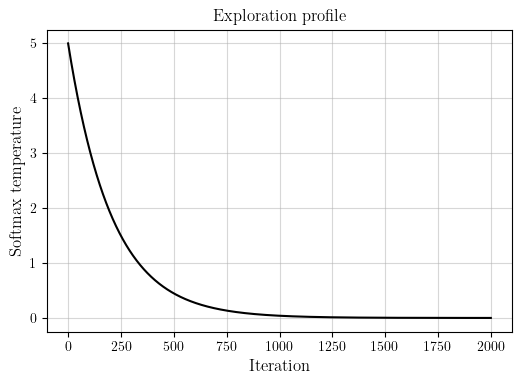

In [48]:
### Define exploration profile
initial_value = 5
num_iterations = 2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(dpi=100)
plt.plot(exploration_profile, c='black')
plt.title('Exploration profile')
plt.grid(alpha=0.5)
plt.xlabel('Iteration', size=12)
plt.ylabel('Softmax temperature', size=12);

## Gym Environment (CartPole-v1)

In [49]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Part 1: Tweak model parameters to speed up learning

In [14]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
    
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [15]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward 0.97
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
fname_out = '{gamma}-{replay_memory_capacity}-{lr}-{target_net_update_steps}-{batch_size}-{bad_state_penalty}-{min_samples_for_training}.h5'.format(
    gamma=gamma,
    replay_memory_capacity=replay_memory_capacity,
    lr=lr,
    target_net_update_steps=target_net_update_steps,
    batch_size=batch_size,
    bad_state_penalty=bad_state_penalty,
    min_samples_for_training=min_samples_for_training)

In [16]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [18]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

episode_scores = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episode_scores.append(score)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_415138/1178835524.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


Updating target network...
EPISODE: 1 - FINAL SCORE: 21 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 20 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 35 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 13 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 34 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 12 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 50 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 11 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 19 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 10 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 14 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 23 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 25 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 9 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

EPISODE: 127 - FINAL SCORE: 25 - Temperature: 1.4809782521904595
EPISODE: 128 - FINAL SCORE: 13 - Temperature: 1.466745826127518
EPISODE: 129 - FINAL SCORE: 12 - Temperature: 1.4526501758418962
EPISODE: 130 - FINAL SCORE: 39 - Temperature: 1.4386899868975886
Updating target network...
EPISODE: 131 - FINAL SCORE: 13 - Temperature: 1.4248639574905198
EPISODE: 132 - FINAL SCORE: 27 - Temperature: 1.4111707983271493
EPISODE: 133 - FINAL SCORE: 16 - Temperature: 1.397609232504243
EPISODE: 134 - FINAL SCORE: 15 - Temperature: 1.3841779953898012
EPISODE: 135 - FINAL SCORE: 21 - Temperature: 1.3708758345051302
EPISODE: 136 - FINAL SCORE: 24 - Temperature: 1.3577015094080467
EPISODE: 137 - FINAL SCORE: 22 - Temperature: 1.344653791577205
EPISODE: 138 - FINAL SCORE: 23 - Temperature: 1.3317314642975362
EPISODE: 139 - FINAL SCORE: 14 - Temperature: 1.3189333225467887
EPISODE: 140 - FINAL SCORE: 31 - Temperature: 1.3062581728831573
Updating target network...
EPISODE: 141 - FINAL SCORE: 51 - Temper

EPISODE: 249 - FINAL SCORE: 48 - Temperature: 0.4559346909764403
EPISODE: 250 - FINAL SCORE: 40 - Temperature: 0.4515530893092621
Updating target network...
EPISODE: 251 - FINAL SCORE: 53 - Temperature: 0.4472135954999631
EPISODE: 252 - FINAL SCORE: 31 - Temperature: 0.44291580488563
EPISODE: 253 - FINAL SCORE: 25 - Temperature: 0.43865931669222175
EPISODE: 254 - FINAL SCORE: 32 - Temperature: 0.4344437339971967
EPISODE: 255 - FINAL SCORE: 19 - Temperature: 0.430268663692499
EPISODE: 256 - FINAL SCORE: 16 - Temperature: 0.4261337164479012
EPISODE: 257 - FINAL SCORE: 50 - Temperature: 0.42203850667469833
EPISODE: 258 - FINAL SCORE: 26 - Temperature: 0.4179826524897514
EPISODE: 259 - FINAL SCORE: 84 - Temperature: 0.4139657756798767
EPISODE: 260 - FINAL SCORE: 28 - Temperature: 0.4099875016665764
Updating target network...
EPISODE: 261 - FINAL SCORE: 78 - Temperature: 0.40604745947110915
EPISODE: 262 - FINAL SCORE: 140 - Temperature: 0.4021452816798956
EPISODE: 263 - FINAL SCORE: 31 - Te

EPISODE: 370 - FINAL SCORE: 186 - Temperature: 0.1417262887221671
Updating target network...
EPISODE: 371 - FINAL SCORE: 81 - Temperature: 0.14036427754986935
EPISODE: 372 - FINAL SCORE: 158 - Temperature: 0.13901535551191777
EPISODE: 373 - FINAL SCORE: 131 - Temperature: 0.13767939681974212
EPISODE: 374 - FINAL SCORE: 124 - Temperature: 0.13635627689361954
EPISODE: 375 - FINAL SCORE: 43 - Temperature: 0.1350458723510572
EPISODE: 376 - FINAL SCORE: 46 - Temperature: 0.13374806099528672
EPISODE: 377 - FINAL SCORE: 122 - Temperature: 0.1324627218038693
EPISODE: 378 - FINAL SCORE: 27 - Temperature: 0.13118973491741018
EPISODE: 379 - FINAL SCORE: 22 - Temperature: 0.1299289816283816
EPISODE: 380 - FINAL SCORE: 147 - Temperature: 0.12868034437005305
Updating target network...
EPISODE: 381 - FINAL SCORE: 39 - Temperature: 0.12744370670552838
EPISODE: 382 - FINAL SCORE: 90 - Temperature: 0.12621895331688754
EPISODE: 383 - FINAL SCORE: 234 - Temperature: 0.12500596999443325
EPISODE: 384 - FINA

EPISODE: 490 - FINAL SCORE: 84 - Temperature: 0.044482789267780265
Updating target network...
EPISODE: 491 - FINAL SCORE: 124 - Temperature: 0.04405530290301379
EPISODE: 492 - FINAL SCORE: 72 - Temperature: 0.04363192474717643
EPISODE: 493 - FINAL SCORE: 116 - Temperature: 0.04321261531975604
EPISODE: 494 - FINAL SCORE: 92 - Temperature: 0.04279733551965424
EPISODE: 495 - FINAL SCORE: 87 - Temperature: 0.04238604662154012
EPISODE: 496 - FINAL SCORE: 164 - Temperature: 0.041978710272239095
EPISODE: 497 - FINAL SCORE: 126 - Temperature: 0.041575288487156414
EPISODE: 498 - FINAL SCORE: 302 - Temperature: 0.04117574364673507
EPISODE: 499 - FINAL SCORE: 204 - Temperature: 0.04078003849294769
EPISODE: 500 - FINAL SCORE: 105 - Temperature: 0.040388136125822205
Updating target network...
EPISODE: 501 - FINAL SCORE: 187 - Temperature: 0.040000000000000924
EPISODE: 502 - FINAL SCORE: 321 - Temperature: 0.039615593921332536
EPISODE: 503 - FINAL SCORE: 110 - Temperature: 0.039234882043497094
EPISO

EPISODE: 607 - FINAL SCORE: 500 - Temperature: 0.014371929182929243
EPISODE: 608 - FINAL SCORE: 500 - Temperature: 0.01423381275942651
EPISODE: 609 - FINAL SCORE: 500 - Temperature: 0.014097023655742735
EPISODE: 610 - FINAL SCORE: 500 - Temperature: 0.013961549116132753
Updating target network...
EPISODE: 611 - FINAL SCORE: 500 - Temperature: 0.013827376507436042
EPISODE: 612 - FINAL SCORE: 500 - Temperature: 0.013694493317898678
EPISODE: 613 - FINAL SCORE: 500 - Temperature: 0.013562887156006585
EPISODE: 614 - FINAL SCORE: 500 - Temperature: 0.013432545749330034
EPISODE: 615 - FINAL SCORE: 500 - Temperature: 0.013303456943379198
EPISODE: 616 - FINAL SCORE: 500 - Temperature: 0.013175608700470751
EPISODE: 617 - FINAL SCORE: 500 - Temperature: 0.013048989098605331
EPISODE: 618 - FINAL SCORE: 500 - Temperature: 0.012923586330355803
EPISODE: 619 - FINAL SCORE: 500 - Temperature: 0.012799388701766197
EPISODE: 620 - FINAL SCORE: 500 - Temperature: 0.012676384631261242
Updating target networ

EPISODE: 723 - FINAL SCORE: 352 - Temperature: 0.00468847868084918
EPISODE: 724 - FINAL SCORE: 447 - Temperature: 0.004643421688233543
EPISODE: 725 - FINAL SCORE: 500 - Temperature: 0.0045987977001641055
EPISODE: 726 - FINAL SCORE: 500 - Temperature: 0.0045546025554013755
EPISODE: 727 - FINAL SCORE: 500 - Temperature: 0.004510832132696006
EPISODE: 728 - FINAL SCORE: 500 - Temperature: 0.004467482350404482
EPISODE: 729 - FINAL SCORE: 500 - Temperature: 0.0044245491661085035
EPISODE: 730 - FINAL SCORE: 330 - Temperature: 0.004382028576238024
Updating target network...
EPISODE: 731 - FINAL SCORE: 411 - Temperature: 0.004339916615697915
EPISODE: 732 - FINAL SCORE: 398 - Temperature: 0.0042982093574982115
EPISODE: 733 - FINAL SCORE: 403 - Temperature: 0.004256902912387922
EPISODE: 734 - FINAL SCORE: 500 - Temperature: 0.004215993428492347
EPISODE: 735 - FINAL SCORE: 500 - Temperature: 0.004175477090953888
EPISODE: 736 - FINAL SCORE: 500 - Temperature: 0.004135350121576308
EPISODE: 737 - FIN

EPISODE: 839 - FINAL SCORE: 500 - Temperature: 0.0015294976798860766
EPISODE: 840 - FINAL SCORE: 500 - Temperature: 0.001514798974749642
Updating target network...
EPISODE: 841 - FINAL SCORE: 500 - Temperature: 0.0015002415264032825
EPISODE: 842 - FINAL SCORE: 500 - Temperature: 0.0014858239773477791
EPISODE: 843 - FINAL SCORE: 500 - Temperature: 0.0014715449831296866
EPISODE: 844 - FINAL SCORE: 500 - Temperature: 0.001457403212215962
EPISODE: 845 - FINAL SCORE: 500 - Temperature: 0.0014433973458697963
EPISODE: 846 - FINAL SCORE: 500 - Temperature: 0.001429526078027643
EPISODE: 847 - FINAL SCORE: 500 - Temperature: 0.0014157881151774234
EPISODE: 848 - FINAL SCORE: 500 - Temperature: 0.0014021821762379074
EPISODE: 849 - FINAL SCORE: 500 - Temperature: 0.0013887069924392503
EPISODE: 850 - FINAL SCORE: 500 - Temperature: 0.0013753613072046771
Updating target network...
EPISODE: 851 - FINAL SCORE: 500 - Temperature: 0.0013621438760333085
EPISODE: 852 - FINAL SCORE: 500 - Temperature: 0.001

EPISODE: 954 - FINAL SCORE: 500 - Temperature: 0.0005038015734614089
EPISODE: 955 - FINAL SCORE: 500 - Temperature: 0.0004989599637793775
EPISODE: 956 - FINAL SCORE: 500 - Temperature: 0.0004941648827021539
EPISODE: 957 - FINAL SCORE: 500 - Temperature: 0.0004894158830827752
EPISODE: 958 - FINAL SCORE: 500 - Temperature: 0.00048471252207142856
EPISODE: 959 - FINAL SCORE: 500 - Temperature: 0.0004800543610741552
EPISODE: 960 - FINAL SCORE: 500 - Temperature: 0.0004754409657119511
Updating target network...
EPISODE: 961 - FINAL SCORE: 500 - Temperature: 0.00047087190578026024
EPISODE: 962 - FINAL SCORE: 500 - Temperature: 0.000466346755208858
EPISODE: 963 - FINAL SCORE: 500 - Temperature: 0.0004618650920221191
EPISODE: 964 - FINAL SCORE: 500 - Temperature: 0.0004574264982996684
EPISODE: 965 - FINAL SCORE: 500 - Temperature: 0.0004530305601374089
EPISODE: 966 - FINAL SCORE: 500 - Temperature: 0.000448676867608925
EPISODE: 967 - FINAL SCORE: 500 - Temperature: 0.00044436501472725615
EPISOD

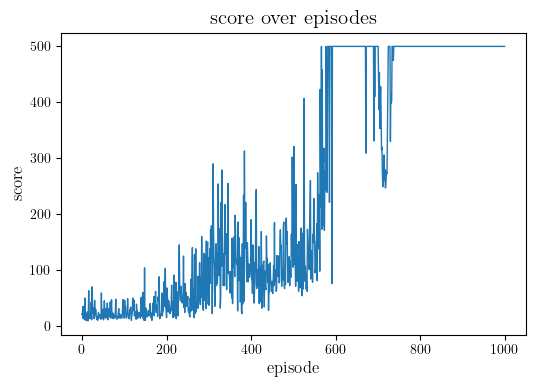

In [19]:
plt.figure(dpi=100)
plt.title('score over episodes', size=15)
plt.xlabel('episode', size=12)
plt.ylabel('score', size=12)
plt.plot(episode_scores, lw=1)

In [90]:
f = h5py.File('scores_history/' + fname_out, 'w')
f.create_dataset('gamma', data=gamma)
f.create_dataset('replay_memory_capacity', data=replay_memory_capacity)
f.create_dataset('lr', data=lr)
f.create_dataset('target_net_update_steps', data=target_net_update_steps)
f.create_dataset('batch_size', data=batch_size)
f.create_dataset('bad_state_penalty', data=bad_state_penalty)
f.create_dataset('min_samples_for_training', data=min_samples_for_training)
f.create_dataset('score_history', data=episode_scores)
f.close()

## Analizing curves

In [20]:
fname_list = os.listdir('scores_history/')
fname_list.remove('.ipynb_checkpoints')

In [21]:
fname_ref = '0.97-10000-0.01-10-128-0-1000.h5'

In [22]:
keys = ['gamma', 'replay_memory_capacity', 'lr', 'target_net_update_steps',
       'batch_size', 'bad_state_penalty', 'min_samples_for_training', 'score_history']

f = h5py.File('scores_history/' + fname_ref, 'r')
all_records = {}
for key in keys:
    all_records[key] = [f[key][()]]
f.close()

for fname in fname_list:
    if fname != fname_ref:
        f = h5py.File('scores_history/' + fname, 'r')
        for key in keys:
            all_records[key].append(f[key][()])
        f.close()

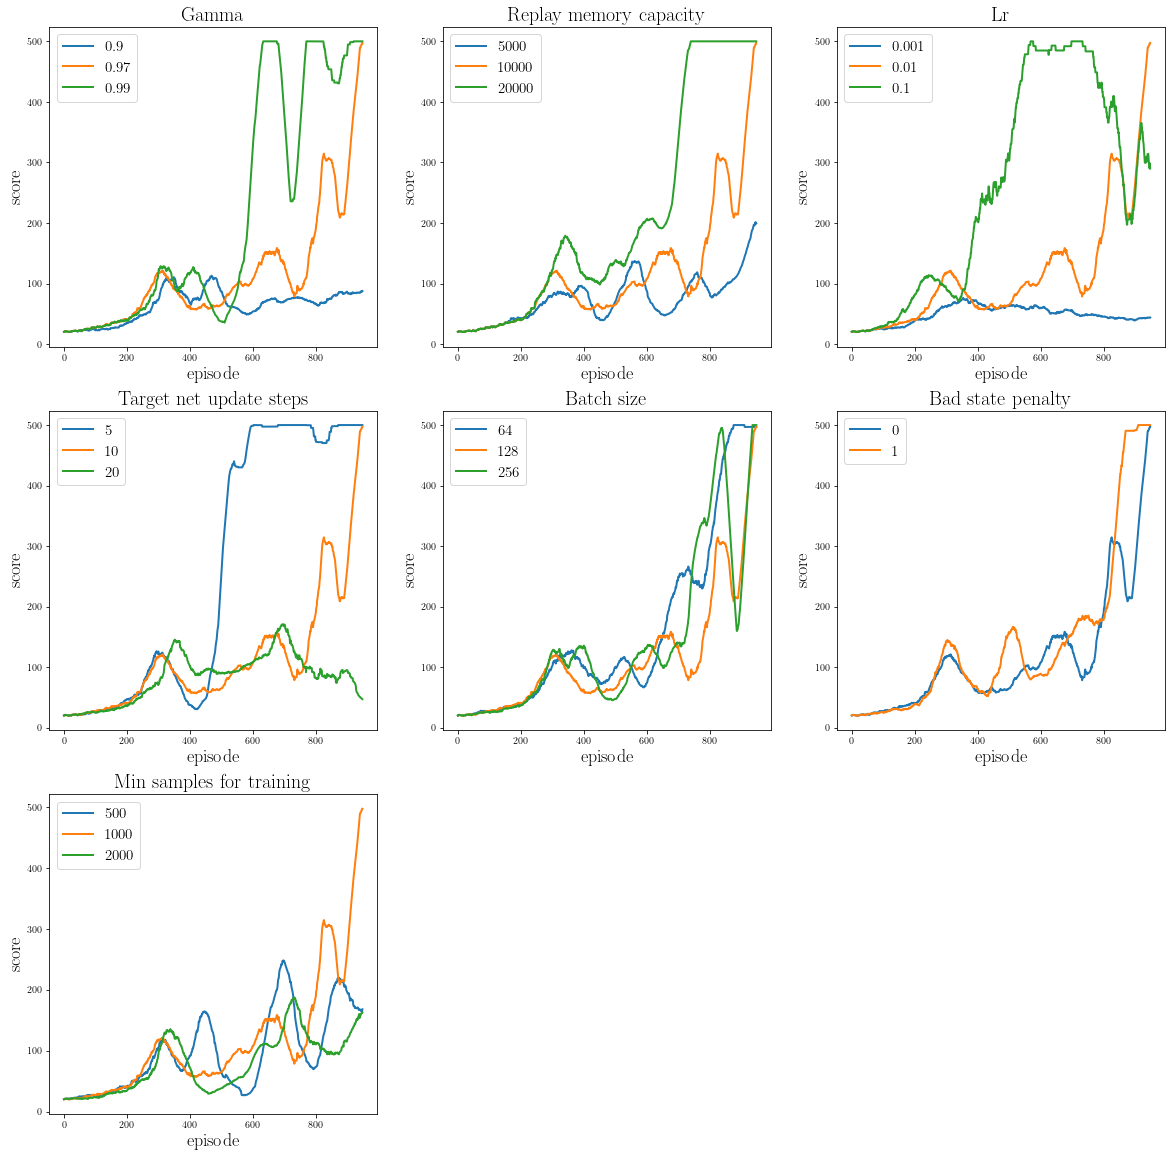

In [23]:
smoothing = 50

fig = plt.figure(figsize=(20, 20))
for i, key in enumerate(keys[:-1]):
    ax = fig.add_subplot(3, 3, i + 1)
    labels, idxs = np.unique(all_records[key], return_index=True)
    ax.set_title(key.replace('_', ' '). capitalize(), size=20)
    ax.set_xlabel('episode', size=18)
    ax.set_ylabel('score', size=18)
    for label, idx in zip(labels, idxs):
        ax.plot(np.convolve(all_records['score_history'][idx], np.ones(smoothing) / smoothing)[smoothing:-smoothing], label=label, lw=2)
    ax.legend(fontsize=15)

# Part 2: use directly the pixels as inputs

### Three images encoding

In [50]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen.mean(0))

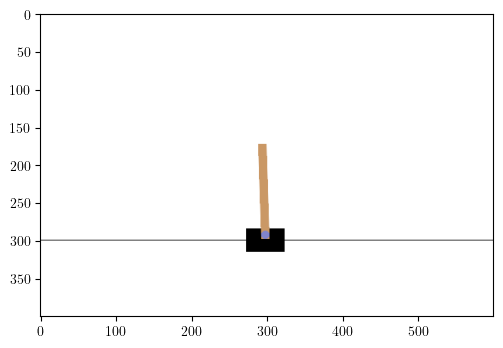

In [51]:
env = gym.make('CartPole-v1')
env.reset()

# let's take the image of the environment and turn it to greyscale
image0 = env.render(mode='rgb_array')

plt.figure(dpi=100)
plt.imshow(image0);

In [52]:
# The network takes as input 3 consecutive frames in grayscale and returns the Q-values
class DQN_3s(nn.Module):

    def __init__(self, h, w, action_space_dim, num_frames):
        super(DQN_3s, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(w))
        convh = conv2d_size_out(conv2d_size_out(h))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, action_space_dim)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return self.head(x.view(x.size(0), -1))

In [53]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
action_space_dim = 2
num_frames = 3

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward 0.97
replay_memory_capacity = 5000   # Replay memory capacity
lr = 1e-4   # Optimizer learning rate
target_net_update_steps = 8   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 1   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [54]:
init_screen = get_screen()
_, screen_height, screen_width = init_screen.shape

### Initialize the replay memory
replay_mem = utilities.ReplayMemory(replay_memory_capacity)

### Initialize the policy network
policy_net = DQN_3s(screen_height, screen_width, action_space_dim, num_frames).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN_3s(screen_height, screen_width, action_space_dim, num_frames).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [55]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

episode_scores = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    env.reset()
    state = []
    rnd_action = np.random.randint(0, 2)
    env.step(rnd_action)
    image = get_screen()
    state.append(image)
    for i in range(1, num_frames):
        rnd_action = np.random.randint(0, 2)
        env.step(rnd_action)
        #image, cart_penalty = get_state(env.render(mode='rgb_array'))
        image = get_screen()
        state.append(image)
    state = torch.cat(state, 0).unsqueeze(0)
        
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    
    # Go on until the pole falls off
    while not done:
        
        # Choose the action following the policy
        action, q_values = utilities.choose_action_softmax(policy_net, state, temperature=tau, device=device)
      
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        _, reward, done, info = env.step(action)
        #next_frame, cart_penalty = get_state(env.render(mode='rgb_array'))
        next_frame = get_screen().unsqueeze(0)
        next_state = torch.cat([state[:, 1:, :, :], next_frame], 1)

        # We apply a (linear) penalty when the cart is far from center
        # The cart position is located in the image at the base of the pole
        pos_weight = 0.
        cart_penalty = np.abs(get_cart_location(screen_width) - screen_width // 2)
        reward = reward - pos_weight * cart_penalty

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

          # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            utilities.update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device)

          # Visually render the environment (disable to speed up the training)
        env.render()

          # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episode_scores.append(score)

env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1 - FINAL SCORE: 8 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 12 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 22 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 11 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 16 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 13 - Temperature: 4.833832910803663
Updating target network...
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 4.787379041949158
EPISODE: 11 - FINAL SCORE: 13 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 9 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 25 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 6 - Temperature: 4.6731881219137215
EPISODE: 16 - FINAL SCORE: 

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 101 - FINAL SCORE: 31 - Temperature: 3.0851693136000358
EPISODE: 102 - FINAL SCORE: 13 - Temperature: 3.0703090520929477
EPISODE: 103 - FINAL SCORE: 14 - Temperature: 3.055520367653311
EPISODE: 104 - FINAL SCORE: 13 - Temperature: 3.040802915517571
Updating target network...
EPISODE: 105 - FINAL SCORE: 6 - Temperature: 3.0261563525827873
EPISODE: 106 - FINAL SCORE: 11 - Temperature: 3.0115803373986343
EPISODE: 107 - FINAL SCORE: 24 - Temperature: 2.997074530159444
EPISODE: 108 - FINAL SCORE: 12 - Temperature: 2.9826385926962793
EPISODE: 109 - FINAL SCORE: 19 - Temperature: 2.968272188469057
EPISODE: 110 - FINAL SCORE: 14 - Temperature: 2.9539749825586963
EPISODE: 111 - FINAL SCORE: 8 - Temperature: 2.9397466416593128
EPISODE: 112 - FINAL SCORE: 9 - Temperature: 2.925586834070449
Updating target network...
EPISODE: 113 - FINAL SCORE: 11 - Temperature: 2.911495229689343
EPISODE: 114 - FINAL SCORE: 22 - Temperature: 2.8974715000032285
EPISODE: 115 - FINAL SCORE: 12 - Temperature:

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 201 - FINAL SCORE: 8 - Temperature: 1.9036539387158633
EPISODE: 202 - FINAL SCORE: 8 - Temperature: 1.894484654157115
EPISODE: 203 - FINAL SCORE: 9 - Temperature: 1.885359535072779
EPISODE: 204 - FINAL SCORE: 40 - Temperature: 1.8762783687320663
EPISODE: 205 - FINAL SCORE: 15 - Temperature: 1.867240943428845
EPISODE: 206 - FINAL SCORE: 16 - Temperature: 1.8582470484767017
EPISODE: 207 - FINAL SCORE: 35 - Temperature: 1.849296474204032
EPISODE: 208 - FINAL SCORE: 8 - Temperature: 1.8403890119491515
Updating target network...
EPISODE: 209 - FINAL SCORE: 16 - Temperature: 1.8315244540554314
EPISODE: 210 - FINAL SCORE: 14 - Temperature: 1.8227025938664583
EPISODE: 211 - FINAL SCORE: 20 - Temperature: 1.8139232257212146
EPISODE: 212 - FINAL SCORE: 6 - Temperature: 1.8051861449492863
EPISODE: 213 - FINAL SCORE: 17 - Temperature: 1.79649114786609
EPISODE: 214 - FINAL SCORE: 15 - Temperature: 1.7878380317681253
EPISODE: 215 - FINAL SCORE: 24 - Temperature: 1

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 301 - FINAL SCORE: 14 - Temperature: 1.1746189430880047
EPISODE: 302 - FINAL SCORE: 7 - Temperature: 1.1689611840183416
EPISODE: 303 - FINAL SCORE: 17 - Temperature: 1.1633306765419535
EPISODE: 304 - FINAL SCORE: 12 - Temperature: 1.1577272893967407
Updating target network...
EPISODE: 305 - FINAL SCORE: 11 - Temperature: 1.1521508919528505
EPISODE: 306 - FINAL SCORE: 12 - Temperature: 1.1466013542096316
EPISODE: 307 - FINAL SCORE: 11 - Temperature: 1.141078546792604
EPISODE: 308 - FINAL SCORE: 17 - Temperature: 1.1355823409504424
EPISODE: 309 - FINAL SCORE: 16 - Temperature: 1.130112608551975
EPISODE: 310 - FINAL SCORE: 17 - Temperature: 1.124669222083197
EPISODE: 311 - FINAL SCORE: 13 - Temperature: 1.1192520546442963
EPISODE: 312 - FINAL SCORE: 9 - Temperature: 1.1138609799466967
Updating target network...
EPISODE: 313 - FINAL SCORE: 40 - Temperature: 1.108495872310113
EPISODE: 314 - FINAL SCORE: 17 - Temperature: 1.1031566066596212
EPISODE: 315 - FINAL SCORE: 22 - Temperatu

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 401 - FINAL SCORE: 10 - Temperature: 0.7247796636776838
EPISODE: 402 - FINAL SCORE: 29 - Temperature: 0.7212886347445904
EPISODE: 403 - FINAL SCORE: 18 - Temperature: 0.7178144209673608
EPISODE: 404 - FINAL SCORE: 11 - Temperature: 0.7143569413528346
EPISODE: 405 - FINAL SCORE: 29 - Temperature: 0.710916115297969
EPISODE: 406 - FINAL SCORE: 9 - Temperature: 0.7074918625879602
EPISODE: 407 - FINAL SCORE: 47 - Temperature: 0.7040841033943729
EPISODE: 408 - FINAL SCORE: 35 - Temperature: 0.7006927582732796
Updating target network...
EPISODE: 409 - FINAL SCORE: 27 - Temperature: 0.6973177481634086
EPISODE: 410 - FINAL SCORE: 15 - Temperature: 0.6939589943843006
EPISODE: 411 - FINAL SCORE: 9 - Temperature: 0.6906164186344748
EPISODE: 412 - FINAL SCORE: 13 - Temperature: 0.6872899429896028
EPISODE: 413 - FINAL SCORE: 8 - Temperature: 0.6839794899006928
EPISODE: 414 - FINAL SCORE: 30 - Temperature: 0.6806849821922817
EPISODE: 415 - FINAL SCORE: 21 - Tempera

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 501 - FINAL SCORE: 13 - Temperature: 0.44721359549994893
EPISODE: 502 - FINAL SCORE: 33 - Temperature: 0.445059512432495
EPISODE: 503 - FINAL SCORE: 36 - Temperature: 0.4429158048856159
EPISODE: 504 - FINAL SCORE: 16 - Temperature: 0.4407824228837891
Updating target network...
EPISODE: 505 - FINAL SCORE: 27 - Temperature: 0.4386593166922077
EPISODE: 506 - FINAL SCORE: 11 - Temperature: 0.43654643681562155
EPISODE: 507 - FINAL SCORE: 24 - Temperature: 0.4344437339971827
EPISODE: 508 - FINAL SCORE: 8 - Temperature: 0.43235115921729794
EPISODE: 509 - FINAL SCORE: 12 - Temperature: 0.4302686636924852
EPISODE: 510 - FINAL SCORE: 47 - Temperature: 0.42819619887423677
EPISODE: 511 - FINAL SCORE: 15 - Temperature: 0.42613371644788745
EPISODE: 512 - FINAL SCORE: 10 - Temperature: 0.424081168331488
Updating target network...
EPISODE: 513 - FINAL SCORE: 23 - Temperature: 0.4220385066746846
EPISODE: 514 - FINAL SCORE: 7 - Temperature: 0.4200056838576028
EPISODE: 515 - FINAL SCORE: 15 - Te

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 601 - FINAL SCORE: 12 - Temperature: 0.2759459322922363
EPISODE: 602 - FINAL SCORE: 9 - Temperature: 0.2746167900965054
EPISODE: 603 - FINAL SCORE: 6 - Temperature: 0.27329404994831263
EPISODE: 604 - FINAL SCORE: 13 - Temperature: 0.27197768101106806
EPISODE: 605 - FINAL SCORE: 41 - Temperature: 0.2706676525967119
EPISODE: 606 - FINAL SCORE: 9 - Temperature: 0.2693639341649985
EPISODE: 607 - FINAL SCORE: 35 - Temperature: 0.268066495322785
EPISODE: 608 - FINAL SCORE: 14 - Temperature: 0.2667753058233222
Updating target network...
EPISODE: 609 - FINAL SCORE: 9 - Temperature: 0.2654903355655498
EPISODE: 610 - FINAL SCORE: 33 - Temperature: 0.2642115545933947
EPISODE: 611 - FINAL SCORE: 39 - Temperature: 0.2629389330950722
EPISODE: 612 - FINAL SCORE: 27 - Temperature: 0.26167244140239165
EPISODE: 613 - FINAL SCORE: 34 - Temperature: 0.2604120499900642
EPISODE: 614 - FINAL SCORE: 14 - Temperature: 0.2591577294750148
EPISODE: 615 - FINAL SCORE: 27 - Tempe

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 701 - FINAL SCORE: 21 - Temperature: 0.17026798450415212
EPISODE: 702 - FINAL SCORE: 7 - Temperature: 0.16944785876101612
EPISODE: 703 - FINAL SCORE: 15 - Temperature: 0.16863168329800188
EPISODE: 704 - FINAL SCORE: 12 - Temperature: 0.16781943908788927
Updating target network...
EPISODE: 705 - FINAL SCORE: 27 - Temperature: 0.1670111071951061
EPISODE: 706 - FINAL SCORE: 13 - Temperature: 0.16620666877528673
EPISODE: 707 - FINAL SCORE: 19 - Temperature: 0.16540610507483275
EPISODE: 708 - FINAL SCORE: 26 - Temperature: 0.1646093974304757
EPISODE: 709 - FINAL SCORE: 19 - Temperature: 0.1638165272688421
EPISODE: 710 - FINAL SCORE: 18 - Temperature: 0.16302747610602036
EPISODE: 711 - FINAL SCORE: 19 - Temperature: 0.16224222554712994
EPISODE: 712 - FINAL SCORE: 18 - Temperature: 0.16146075728589243
Updating target network...
EPISODE: 713 - FINAL SCORE: 9 - Temperature: 0.1606830531042049
EPISODE: 714 - FINAL SCORE: 18 - Temperature: 0.159909094871715
EPISODE: 715 - FINAL SCORE: 14

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 801 - FINAL SCORE: 12 - Temperature: 0.1050611121761473
EPISODE: 802 - FINAL SCORE: 14 - Temperature: 0.10455506682094398
EPISODE: 803 - FINAL SCORE: 17 - Temperature: 0.10405145892234302
EPISODE: 804 - FINAL SCORE: 17 - Temperature: 0.10355027673990526
EPISODE: 805 - FINAL SCORE: 19 - Temperature: 0.10305150858974149
EPISODE: 806 - FINAL SCORE: 11 - Temperature: 0.10255514284423997
EPISODE: 807 - FINAL SCORE: 9 - Temperature: 0.10206116793179543
EPISODE: 808 - FINAL SCORE: 22 - Temperature: 0.10156957233653924
Updating target network...
EPISODE: 809 - FINAL SCORE: 18 - Temperature: 0.10108034459807103
EPISODE: 810 - FINAL SCORE: 29 - Temperature: 0.10059347331119142
EPISODE: 811 - FINAL SCORE: 9 - Temperature: 0.10010894712563623
EPISODE: 812 - FINAL SCORE: 15 - Temperature: 0.09962675474581176
EPISODE: 813 - FINAL SCORE: 16 - Temperature: 0.09914688493053157
EPISODE: 814 - FINAL SCORE: 35 - Temperature: 0.09866932649275441
EPISODE: 815 - FINAL SCOR

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 901 - FINAL SCORE: 85 - Temperature: 0.06482626386770814
EPISODE: 902 - FINAL SCORE: 61 - Temperature: 0.06451401674747553
EPISODE: 903 - FINAL SCORE: 285 - Temperature: 0.06420327362050547
EPISODE: 904 - FINAL SCORE: 88 - Temperature: 0.06389402724254946
Updating target network...
EPISODE: 905 - FINAL SCORE: 33 - Temperature: 0.06358627040425219
EPISODE: 906 - FINAL SCORE: 147 - Temperature: 0.06327999593098349
EPISODE: 907 - FINAL SCORE: 146 - Temperature: 0.06297519668267106
EPISODE: 908 - FINAL SCORE: 158 - Temperature: 0.06267186555363399
EPISODE: 909 - FINAL SCORE: 245 - Temperature: 0.06236999547241717
EPISODE: 910 - FINAL SCORE: 129 - Temperature: 0.062069579401626385
EPISODE: 911 - FINAL SCORE: 164 - Temperature: 0.06177061033776427
EPISODE: 912 - FINAL SCORE: 137 - Temperature: 0.061473081311067025
Updating target network...
EPISODE: 913 - FINAL SCORE: 159 - Temperature: 0.06117698538534197
EPISODE: 914 - FINAL SCORE: 57 - Temperature: 0.06088231565780579
EPISODE: 91

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1001 - FINAL SCORE: 41 - Temperature: 0.039999999999998384
EPISODE: 1002 - FINAL SCORE: 46 - Temperature: 0.039807332953278055
EPISODE: 1003 - FINAL SCORE: 26 - Temperature: 0.03961559392133003
EPISODE: 1004 - FINAL SCORE: 51 - Temperature: 0.039424778434207663
EPISODE: 1005 - FINAL SCORE: 35 - Temperature: 0.039234882043494596
EPISODE: 1006 - FINAL SCORE: 10 - Temperature: 0.03904590032220107
EPISODE: 1007 - FINAL SCORE: 11 - Temperature: 0.0388578288646607
EPISODE: 1008 - FINAL SCORE: 14 - Temperature: 0.03867066328642774
Updating target network...
EPISODE: 1009 - FINAL SCORE: 15 - Temperature: 0.038484399224174924
EPISODE: 1010 - FINAL SCORE: 39 - Temperature: 0.03829903233559172
EPISODE: 1011 - FINAL SCORE: 27 - Temperature: 0.03811455829928309
EPISODE: 1012 - FINAL SCORE: 13 - Temperature: 0.03793097281466877
EPISODE: 1013 - FINAL SCORE: 39 - Temperature: 0.037748271601882974
EPISODE: 1014 - FINAL SCORE: 12 - Temperature: 0.03756645040167468
EPI

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 1101 - FINAL SCORE: 149 - Temperature: 0.02468135450879929
EPISODE: 1102 - FINAL SCORE: 184 - Temperature: 0.02456247241674259
EPISODE: 1103 - FINAL SCORE: 107 - Temperature: 0.024444162941225502
EPISODE: 1104 - FINAL SCORE: 150 - Temperature: 0.024326423324139583
Updating target network...
EPISODE: 1105 - FINAL SCORE: 151 - Temperature: 0.024209250820661322
EPISODE: 1106 - FINAL SCORE: 62 - Temperature: 0.024092642699188104
EPISODE: 1107 - FINAL SCORE: 184 - Temperature: 0.02397659624127458
EPISODE: 1108 - FINAL SCORE: 131 - Temperature: 0.023861108741569274
EPISODE: 1109 - FINAL SCORE: 109 - Temperature: 0.023746177507751497
EPISODE: 1110 - FINAL SCORE: 115 - Temperature: 0.02363179986046862
EPISODE: 1111 - FINAL SCORE: 130 - Temperature: 0.02351797313327355
EPISODE: 1112 - FINAL SCORE: 138 - Temperature: 0.023404694672562655
Updating target network...
EPISODE: 1113 - FINAL SCORE: 113 - Temperature: 0.023291961837513805
EPISODE: 1114 - FINAL SCORE: 126 - Temperature: 0.02317

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1201 - FINAL SCORE: 124 - Temperature: 0.01522923150972629
EPISODE: 1202 - FINAL SCORE: 100 - Temperature: 0.015155877233256308
EPISODE: 1203 - FINAL SCORE: 84 - Temperature: 0.015082876280581622
EPISODE: 1204 - FINAL SCORE: 96 - Temperature: 0.015010226949855926
EPISODE: 1205 - FINAL SCORE: 87 - Temperature: 0.014937927547430155
EPISODE: 1206 - FINAL SCORE: 96 - Temperature: 0.014865976387813014
EPISODE: 1207 - FINAL SCORE: 155 - Temperature: 0.01479437179363166
EPISODE: 1208 - FINAL SCORE: 96 - Temperature: 0.014723112095592617
Updating target network...
EPISODE: 1209 - FINAL SCORE: 98 - Temperature: 0.014652195632442862
EPISODE: 1210 - FINAL SCORE: 110 - Temperature: 0.014581620750931076
EPISODE: 1211 - FINAL SCORE: 90 - Temperature: 0.01451138580576913
EPISODE: 1212 - FINAL SCORE: 103 - Temperature: 0.014441489159593705
EPISODE: 1213 - FINAL SCORE: 119 - Temperature: 0.014371929182928138
EPISODE: 1214 - FINAL SCORE: 195 - Temperature: 0.014302704

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 1301 - FINAL SCORE: 94 - Temperature: 0.00939695154470366
EPISODE: 1302 - FINAL SCORE: 110 - Temperature: 0.009351689472146355
EPISODE: 1303 - FINAL SCORE: 93 - Temperature: 0.009306645412335252
EPISODE: 1304 - FINAL SCORE: 101 - Temperature: 0.009261818315173552
Updating target network...
EPISODE: 1305 - FINAL SCORE: 88 - Temperature: 0.009217207135622433
EPISODE: 1306 - FINAL SCORE: 89 - Temperature: 0.009172810833676683
EPISODE: 1307 - FINAL SCORE: 89 - Temperature: 0.009128628374340463
EPISODE: 1308 - FINAL SCORE: 89 - Temperature: 0.009084658727603171
EPISODE: 1309 - FINAL SCORE: 118 - Temperature: 0.009040900868415436
EPISODE: 1310 - FINAL SCORE: 110 - Temperature: 0.008997353776665214
EPISODE: 1311 - FINAL SCORE: 108 - Temperature: 0.00895401643715401
EPISODE: 1312 - FINAL SCORE: 89 - Temperature: 0.008910887839573214
Updating target network...
EPISODE: 1313 - FINAL SCORE: 89 - Temperature: 0.008867966978480545
EPISODE: 1314 - FINAL SCORE: 84 - Temperature: 0.0088252528

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1401 - FINAL SCORE: 83 - Temperature: 0.005798237309421237
EPISODE: 1402 - FINAL SCORE: 199 - Temperature: 0.005770309077956491
EPISODE: 1403 - FINAL SCORE: 90 - Temperature: 0.005742515367738655
EPISODE: 1404 - FINAL SCORE: 157 - Temperature: 0.0057148555308224455
EPISODE: 1405 - FINAL SCORE: 88 - Temperature: 0.005687328922383522
EPISODE: 1406 - FINAL SCORE: 83 - Temperature: 0.005659934900703453
EPISODE: 1407 - FINAL SCORE: 96 - Temperature: 0.0056326728271547544
EPISODE: 1408 - FINAL SCORE: 109 - Temperature: 0.0056055420661860105
Updating target network...
EPISODE: 1409 - FINAL SCORE: 101 - Temperature: 0.005578541985307044
EPISODE: 1410 - FINAL SCORE: 86 - Temperature: 0.0055516719550741805
EPISODE: 1411 - FINAL SCORE: 110 - Temperature: 0.005524931349075575
EPISODE: 1412 - FINAL SCORE: 77 - Temperature: 0.0054983195439166
EPISODE: 1413 - FINAL SCORE: 86 - Temperature: 0.005471835919205322
EPISODE: 1414 - FINAL SCORE: 89 - Temperature: 0.005445

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 1501 - FINAL SCORE: 87 - Temperature: 0.003577708763999447
EPISODE: 1502 - FINAL SCORE: 86 - Temperature: 0.003560476099459816
EPISODE: 1503 - FINAL SCORE: 84 - Temperature: 0.003543326439084784
EPISODE: 1504 - FINAL SCORE: 84 - Temperature: 0.0035262593830701705
Updating target network...
EPISODE: 1505 - FINAL SCORE: 88 - Temperature: 0.0035092745335375207
EPISODE: 1506 - FINAL SCORE: 87 - Temperature: 0.003492371494524831
EPISODE: 1507 - FINAL SCORE: 141 - Temperature: 0.0034755498719773216
EPISODE: 1508 - FINAL SCORE: 86 - Temperature: 0.003458809273738244
EPISODE: 1509 - FINAL SCORE: 80 - Temperature: 0.0034421493095397426
EPISODE: 1510 - FINAL SCORE: 74 - Temperature: 0.003425569590993756
EPISODE: 1511 - FINAL SCORE: 114 - Temperature: 0.0034090697315829616
EPISODE: 1512 - FINAL SCORE: 80 - Temperature: 0.0033926493466517674
Updating target network...
EPISODE: 1513 - FINAL SCORE: 93 - Temperature: 0.00337630805339734
EPISODE: 1514 - FINAL SCORE: 86 - Temperature: 0.003360

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1601 - FINAL SCORE: 125 - Temperature: 0.002207567458337801
EPISODE: 1602 - FINAL SCORE: 110 - Temperature: 0.0021969343207719544
EPISODE: 1603 - FINAL SCORE: 94 - Temperature: 0.0021863523995864125
EPISODE: 1604 - FINAL SCORE: 82 - Temperature: 0.0021758214480884566
EPISODE: 1605 - FINAL SCORE: 78 - Temperature: 0.0021653412207736076
EPISODE: 1606 - FINAL SCORE: 93 - Temperature: 0.0021549114733199013
EPISODE: 1607 - FINAL SCORE: 129 - Temperature: 0.002144531962582193
EPISODE: 1608 - FINAL SCORE: 77 - Temperature: 0.0021342024465864913
Updating target network...
EPISODE: 1609 - FINAL SCORE: 81 - Temperature: 0.002123922684524313
EPISODE: 1610 - FINAL SCORE: 90 - Temperature: 0.002113692436747072
EPISODE: 1611 - FINAL SCORE: 86 - Temperature: 0.002103511464760493
EPISODE: 1612 - FINAL SCORE: 138 - Temperature: 0.0020933795312190486
EPISODE: 1613 - FINAL SCORE: 101 - Temperature: 0.0020832963999204293
EPISODE: 1614 - FINAL SCORE: 82 - Temperature: 0.

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 1701 - FINAL SCORE: 87 - Temperature: 0.0013621438760331617
EPISODE: 1702 - FINAL SCORE: 76 - Temperature: 0.0013555828700880742
EPISODE: 1703 - FINAL SCORE: 91 - Temperature: 0.0013490534663839608
EPISODE: 1704 - FINAL SCORE: 87 - Temperature: 0.00134255551270306
Updating target network...
EPISODE: 1705 - FINAL SCORE: 82 - Temperature: 0.0013360888575607948
EPISODE: 1706 - FINAL SCORE: 101 - Temperature: 0.0013296533502022401
EPISODE: 1707 - FINAL SCORE: 105 - Temperature: 0.0013232488405986085
EPISODE: 1708 - FINAL SCORE: 93 - Temperature: 0.0013168751794437523
EPISODE: 1709 - FINAL SCORE: 84 - Temperature: 0.0013105322181506838
EPISODE: 1710 - FINAL SCORE: 103 - Temperature: 0.0013042198088481104
EPISODE: 1711 - FINAL SCORE: 80 - Temperature: 0.0012979378043769872
EPISODE: 1712 - FINAL SCORE: 83 - Temperature: 0.0012916860582870874
Updating target network...
EPISODE: 1713 - FINAL SCORE: 105 - Temperature: 0.0012854644248335872
EPISODE: 1714 - FINAL SCORE: 77 - Temperature: 

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1801 - FINAL SCORE: 84 - Temperature: 0.0008404888974091444
EPISODE: 1802 - FINAL SCORE: 78 - Temperature: 0.0008364405345675182
EPISODE: 1803 - FINAL SCORE: 93 - Temperature: 0.0008324116713787106
EPISODE: 1804 - FINAL SCORE: 77 - Temperature: 0.0008284022139192087
EPISODE: 1805 - FINAL SCORE: 87 - Temperature: 0.0008244120687178986
EPISODE: 1806 - FINAL SCORE: 112 - Temperature: 0.0008204411427538866
EPISODE: 1807 - FINAL SCORE: 98 - Temperature: 0.0008164893434543304
EPISODE: 1808 - FINAL SCORE: 87 - Temperature: 0.000812556578692281
Updating target network...
EPISODE: 1809 - FINAL SCORE: 104 - Temperature: 0.0008086427567845355
EPISODE: 1810 - FINAL SCORE: 78 - Temperature: 0.0008047477864894988
EPISODE: 1811 - FINAL SCORE: 151 - Temperature: 0.0008008715770050573
EPISODE: 1812 - FINAL SCORE: 105 - Temperature: 0.0007970140379664619
EPISODE: 1813 - FINAL SCORE: 104 - Temperature: 0.0007931750794442206
EPISODE: 1814 - FINAL SCORE: 86 - Temperature

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


EPISODE: 1901 - FINAL SCORE: 132 - Temperature: 0.0005186101109416442
EPISODE: 1902 - FINAL SCORE: 111 - Temperature: 0.0005161121339797833
EPISODE: 1903 - FINAL SCORE: 89 - Temperature: 0.000513626188964023
EPISODE: 1904 - FINAL SCORE: 126 - Temperature: 0.000511152217940375
Updating target network...
EPISODE: 1905 - FINAL SCORE: 113 - Temperature: 0.000508690163233997
EPISODE: 1906 - FINAL SCORE: 87 - Temperature: 0.0005062399674478474
EPISODE: 1907 - FINAL SCORE: 92 - Temperature: 0.0005038015734613481
EPISODE: 1908 - FINAL SCORE: 101 - Temperature: 0.0005013749244290516
EPISODE: 1909 - FINAL SCORE: 107 - Temperature: 0.0004989599637793172
EPISODE: 1910 - FINAL SCORE: 118 - Temperature: 0.000496556635212991
EPISODE: 1911 - FINAL SCORE: 78 - Temperature: 0.0004941648827020942
EPISODE: 1912 - FINAL SCORE: 95 - Temperature: 0.0004917846504885163
Updating target network...
EPISODE: 1913 - FINAL SCORE: 98 - Temperature: 0.000489415883082716
EPISODE: 1914 - FINAL SCORE: 114 - Temperature:

In [42]:
show_videos()


SHOWING VIDEO video/openaigym.video.4.584711.video000000.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000100.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000200.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000300.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000400.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000500.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000600.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000700.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000800.mp4



SHOWING VIDEO video/openaigym.video.4.584711.video000900.mp4


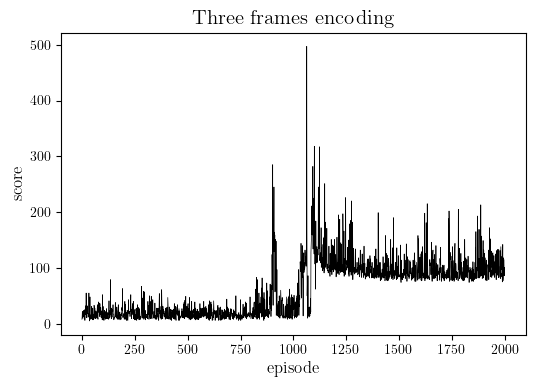

In [56]:
plt.figure(dpi=100)
plt.title('Three frames encoding', size=15)
plt.xlabel('episode', size=12)
plt.ylabel('score', size=12)
plt.plot(episode_scores, lw=0.5, color='black');

### Two images encoding

In [68]:
env = gym.make('CartPole-v1')
env.reset();

In [69]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
action_space_dim = 2

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward 0.97
replay_memory_capacity = 5000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0.5   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [70]:
init_screen = get_screen()
_, screen_height, screen_width = init_screen.shape

### Initialize the replay memory
replay_mem = utilities.ReplayMemory(replay_memory_capacity)

### Initialize the policy network
num_frames = 5
policy_net = DQN_3s(screen_height, screen_width, action_space_dim, num_frames).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN_3s(screen_height, screen_width, action_space_dim, num_frames).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [71]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

episode_scores = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    env.reset()
    state = []
    for i in range(num_frames):
        rnd_action = np.random.randint(0, 2)
        env.step(rnd_action)
        #image, cart_penalty = get_state(env.render(mode='rgb_array'))
        image = get_screen()
        state.append(image)
    state = torch.cat(state, 0).unsqueeze(0)
        
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    
    # Go on until the pole falls off
    while not done:
        
        # Choose the action following the policy
        action, q_values = utilities.choose_action_softmax(policy_net, state, temperature=tau, device=device)
      
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        _, reward, done, info = env.step(action)
        #next_frame, cart_penalty = get_state(env.render(mode='rgb_array'))
        next_frame = get_screen().unsqueeze(0)
        next_state = torch.cat([state[:, 1:, :, :], next_frame], 1)

        # We apply a (linear) penalty when the cart is far from center
        # The cart position is located in the image at the base of the pole
        pos_weight = 0.
        cart_penalty = np.abs(get_cart_location(screen_width) - screen_width // 2)
        reward = reward - pos_weight * cart_penalty

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

          # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            utilities.update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device)

          # Visually render the environment (disable to speed up the training)
        env.render()

          # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episode_scores.append(score)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 1 - FINAL SCORE: 15 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 5 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 31 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 16 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 4 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 15 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 37 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 43 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 17 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 9 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 19 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 7 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 16 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 4 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCORE: 1

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 101 - FINAL SCORE: 13 - Temperature: 1.903653938715887
EPISODE: 102 - FINAL SCORE: 27 - Temperature: 1.8853595350728032
EPISODE: 103 - FINAL SCORE: 14 - Temperature: 1.8672409434288693
EPISODE: 104 - FINAL SCORE: 12 - Temperature: 1.849296474204056
EPISODE: 105 - FINAL SCORE: 19 - Temperature: 1.8315244540554556
EPISODE: 106 - FINAL SCORE: 38 - Temperature: 1.8139232257212385
EPISODE: 107 - FINAL SCORE: 20 - Temperature: 1.796491147866114
EPISODE: 108 - FINAL SCORE: 14 - Temperature: 1.7792265949282728
EPISODE: 109 - FINAL SCORE: 32 - Temperature: 1.7621279569678014
EPISODE: 110 - FINAL SCORE: 10 - Temperature: 1.745193639516554
Updating target network...
EPISODE: 111 - FINAL SCORE: 18 - Temperature: 1.7284220634294656
EPISODE: 112 - FINAL SCORE: 22 - Temperature: 1.7118116647372952
EPISODE: 113 - FINAL SCORE: 18 - Temperature: 1.6953608945007845
EPISODE: 114 - FINAL SCORE: 16 - Temperature: 1.6790682186662158
EPISODE: 115 - FINAL SCORE: 26 - Tempera

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 201 - FINAL SCORE: 20 - Temperature: 0.7247796636777022
EPISODE: 202 - FINAL SCORE: 17 - Temperature: 0.7178144209673791
EPISODE: 203 - FINAL SCORE: 17 - Temperature: 0.7109161152979872
EPISODE: 204 - FINAL SCORE: 9 - Temperature: 0.704084103394391
EPISODE: 205 - FINAL SCORE: 19 - Temperature: 0.6973177481634265
EPISODE: 206 - FINAL SCORE: 10 - Temperature: 0.6906164186344926
EPISODE: 207 - FINAL SCORE: 6 - Temperature: 0.6839794899007107
EPISODE: 208 - FINAL SCORE: 5 - Temperature: 0.6774063430606526
EPISODE: 209 - FINAL SCORE: 17 - Temperature: 0.670896365160627
EPISODE: 210 - FINAL SCORE: 10 - Temperature: 0.6644489491375205
Updating target network...
EPISODE: 211 - FINAL SCORE: 15 - Temperature: 0.6580634937621886
EPISODE: 212 - FINAL SCORE: 17 - Temperature: 0.6517394035833903
EPISODE: 213 - FINAL SCORE: 25 - Temperature: 0.6454760888722616
EPISODE: 214 - FINAL SCORE: 24 - Temperature: 0.6392729655673222
EPISODE: 215 - FINAL SCORE: 8 - Temperatu

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 301 - FINAL SCORE: 12 - Temperature: 0.27594593229224673
EPISODE: 302 - FINAL SCORE: 10 - Temperature: 0.273294049948323
EPISODE: 303 - FINAL SCORE: 26 - Temperature: 0.2706676525967222
EPISODE: 304 - FINAL SCORE: 23 - Temperature: 0.26806649532279525
EPISODE: 305 - FINAL SCORE: 16 - Temperature: 0.26549033556556006
EPISODE: 306 - FINAL SCORE: 11 - Temperature: 0.26293893309508237
EPISODE: 307 - FINAL SCORE: 14 - Temperature: 0.2604120499900742
EPISODE: 308 - FINAL SCORE: 9 - Temperature: 0.25790945061570736
EPISODE: 309 - FINAL SCORE: 18 - Temperature: 0.25543090160163995
EPISODE: 310 - FINAL SCORE: 14 - Temperature: 0.2529761718202546
Updating target network...
EPISODE: 311 - FINAL SCORE: 12 - Temperature: 0.2505450323651056
EPISODE: 312 - FINAL SCORE: 5 - Temperature: 0.24813725652957286
EPISODE: 313 - FINAL SCORE: 24 - Temperature: 0.24575261978572138
EPISODE: 314 - FINAL SCORE: 10 - Temperature: 0.24339089976336367
EPISODE: 315 - FINAL SCORE: 13

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 401 - FINAL SCORE: 26 - Temperature: 0.1050611121761526
EPISODE: 402 - FINAL SCORE: 50 - Temperature: 0.10405145892234831
EPISODE: 403 - FINAL SCORE: 191 - Temperature: 0.10305150858974674
EPISODE: 404 - FINAL SCORE: 75 - Temperature: 0.10206116793180063
EPISODE: 405 - FINAL SCORE: 7 - Temperature: 0.10108034459807619
EPISODE: 406 - FINAL SCORE: 170 - Temperature: 0.10010894712564133
EPISODE: 407 - FINAL SCORE: 19 - Temperature: 0.09914688493053667
EPISODE: 408 - FINAL SCORE: 125 - Temperature: 0.09819406829932839
EPISODE: 409 - FINAL SCORE: 227 - Temperature: 0.0972504083807424
EPISODE: 410 - FINAL SCORE: 60 - Temperature: 0.09631581717737896
Updating target network...
EPISODE: 411 - FINAL SCORE: 176 - Temperature: 0.09539020753750654
EPISODE: 412 - FINAL SCORE: 142 - Temperature: 0.09447349314693518
EPISODE: 413 - FINAL SCORE: 293 - Temperature: 0.09356558852096727
EPISODE: 414 - FINAL SCORE: 191 - Temperature: 0.09266640899642618
EPISODE: 415 - FI

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 501 - FINAL SCORE: 182 - Temperature: 0.040000000000000924
EPISODE: 502 - FINAL SCORE: 284 - Temperature: 0.039615593921332536
EPISODE: 503 - FINAL SCORE: 98 - Temperature: 0.039234882043497094
EPISODE: 504 - FINAL SCORE: 141 - Temperature: 0.03885782886466317
EPISODE: 505 - FINAL SCORE: 231 - Temperature: 0.03848439922417738
EPISODE: 506 - FINAL SCORE: 363 - Temperature: 0.038114558299285534
EPISODE: 507 - FINAL SCORE: 253 - Temperature: 0.037748271601885396
EPISODE: 508 - FINAL SCORE: 286 - Temperature: 0.037385504975310666
EPISODE: 509 - FINAL SCORE: 175 - Temperature: 0.03702622459114576
EPISODE: 510 - FINAL SCORE: 292 - Temperature: 0.03667039694607135
Updating target network...
EPISODE: 511 - FINAL SCORE: 165 - Temperature: 0.036317988858740054
EPISODE: 512 - FINAL SCORE: 37 - Temperature: 0.03596896746668231
EPISODE: 513 - FINAL SCORE: 156 - Temperature: 0.03562330022324187
EPISODE: 514 - FINAL SCORE: 225 - Temperature: 0.03528095489454081
EPI

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 601 - FINAL SCORE: 186 - Temperature: 0.015229231509727447
EPISODE: 602 - FINAL SCORE: 13 - Temperature: 0.015082876280582769
EPISODE: 603 - FINAL SCORE: 85 - Temperature: 0.014937927547431297
EPISODE: 604 - FINAL SCORE: 63 - Temperature: 0.014794371793632789
EPISODE: 605 - FINAL SCORE: 149 - Temperature: 0.014652195632443979
EPISODE: 606 - FINAL SCORE: 127 - Temperature: 0.01451138580577024
EPISODE: 607 - FINAL SCORE: 137 - Temperature: 0.014371929182929243
EPISODE: 608 - FINAL SCORE: 155 - Temperature: 0.01423381275942651
EPISODE: 609 - FINAL SCORE: 146 - Temperature: 0.014097023655742735
EPISODE: 610 - FINAL SCORE: 197 - Temperature: 0.013961549116132753
Updating target network...
EPISODE: 611 - FINAL SCORE: 34 - Temperature: 0.013827376507436042
EPISODE: 612 - FINAL SCORE: 123 - Temperature: 0.013694493317898678
EPISODE: 613 - FINAL SCORE: 75 - Temperature: 0.013562887156006585
EPISODE: 614 - FINAL SCORE: 77 - Temperature: 0.013432545749330034
EP

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 701 - FINAL SCORE: 46 - Temperature: 0.00579823730942175
EPISODE: 702 - FINAL SCORE: 133 - Temperature: 0.005742515367739165
EPISODE: 703 - FINAL SCORE: 10 - Temperature: 0.005687328922384028
EPISODE: 704 - FINAL SCORE: 40 - Temperature: 0.005632672827155257
EPISODE: 705 - FINAL SCORE: 68 - Temperature: 0.0055785419853075415
EPISODE: 706 - FINAL SCORE: 73 - Temperature: 0.005524931349076067
EPISODE: 707 - FINAL SCORE: 10 - Temperature: 0.00547183591920581
EPISODE: 708 - FINAL SCORE: 11 - Temperature: 0.005419250744485345
EPISODE: 709 - FINAL SCORE: 116 - Temperature: 0.0053671709212851386
EPISODE: 710 - FINAL SCORE: 16 - Temperature: 0.005315591593100286
Updating target network...
EPISODE: 711 - FINAL SCORE: 89 - Temperature: 0.005264507950097631
EPISODE: 712 - FINAL SCORE: 85 - Temperature: 0.005213915228667243
EPISODE: 713 - FINAL SCORE: 122 - Temperature: 0.005163808710978211
EPISODE: 714 - FINAL SCORE: 113 - Temperature: 0.005114183724538694
EPIS

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 801 - FINAL SCORE: 163 - Temperature: 0.0022075674583380248
EPISODE: 802 - FINAL SCORE: 114 - Temperature: 0.0021863523995866345
EPISODE: 803 - FINAL SCORE: 84 - Temperature: 0.0021653412207738275
EPISODE: 804 - FINAL SCORE: 128 - Temperature: 0.002144531962582411
EPISODE: 805 - FINAL SCORE: 95 - Temperature: 0.002123922684524529
EPISODE: 806 - FINAL SCORE: 140 - Temperature: 0.002103511464760707
EPISODE: 807 - FINAL SCORE: 55 - Temperature: 0.002083296399920642
EPISODE: 808 - FINAL SCORE: 139 - Temperature: 0.002063275604925706
EPISODE: 809 - FINAL SCORE: 66 - Temperature: 0.0020434472128131663
EPISODE: 810 - FINAL SCORE: 12 - Temperature: 0.0020238093745620833
Updating target network...
EPISODE: 811 - FINAL SCORE: 102 - Temperature: 0.002004360258920891
EPISODE: 812 - FINAL SCORE: 97 - Temperature: 0.0019850980522366285
EPISODE: 813 - FINAL SCORE: 102 - Temperature: 0.001966020958285816
EPISODE: 814 - FINAL SCORE: 102 - Temperature: 0.0019471271981

/home/lorenzo.rosset/NNDL/Homework3/utilities.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Updating target network...
EPISODE: 901 - FINAL SCORE: 85 - Temperature: 0.0008404888974092403
EPISODE: 902 - FINAL SCORE: 85 - Temperature: 0.0008324116713788054
EPISODE: 903 - FINAL SCORE: 73 - Temperature: 0.0008244120687179927
EPISODE: 904 - FINAL SCORE: 112 - Temperature: 0.0008164893434544239
EPISODE: 905 - FINAL SCORE: 17 - Temperature: 0.0008086427567846281
EPISODE: 906 - FINAL SCORE: 91 - Temperature: 0.0008008715770051492
EPISODE: 907 - FINAL SCORE: 88 - Temperature: 0.0007931750794443116
EPISODE: 908 - FINAL SCORE: 101 - Temperature: 0.0007855525463946451
EPISODE: 909 - FINAL SCORE: 121 - Temperature: 0.0007780032670459572
EPISODE: 910 - FINAL SCORE: 80 - Temperature: 0.0007705265374190493
Updating target network...
EPISODE: 911 - FINAL SCORE: 112 - Temperature: 0.0007631216603000699
EPISODE: 912 - FINAL SCORE: 102 - Temperature: 0.0007557879451754988
EPISODE: 913 - FINAL SCORE: 78 - Temperature: 0.0007485247081677553
EPISODE: 914 - FINAL SCORE: 84 - Temperature: 0.000741331

In [67]:
show_videos()


SHOWING VIDEO video/openaigym.video.9.415138.video000000.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000100.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000200.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000300.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000400.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000500.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000600.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000700.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000800.mp4



SHOWING VIDEO video/openaigym.video.9.415138.video000900.mp4


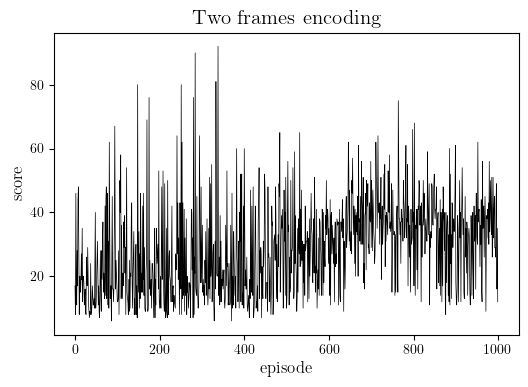

In [26]:
plt.figure(dpi=100)
plt.title('Two frames encoding', size=15)
plt.xlabel('episode', size=12)
plt.ylabel('score', size=12)
plt.plot(episode_scores, lw=0.5, color='black');